PROGRAMMING ASSIGNMENT
---
Quirante, John Clement J.

Legaspi, Light Pearl R.

This assignment is a test of your algorithmic thinking. You can use any A.I. tools ot assist you in this coding assignment.

Instructions:

- This is done by pair, preferably your thesis partner.
- Each person should create a Github Repo titled 'Assignment_1_Data_Analytics'.
- Read the journal provided.
- Develop a Python implementation of the procedures in the journal.
- Deadline is before premidterm week.

# **Balanced Risk Set Matching**



## Import Required Libraries

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import wilcoxon
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, PULP_CBC_CMD
import statsmodels.stats.descriptivestats as smd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Display confirmation message
print("Libraries imported successfully!")

Libraries imported successfully!


## Load Patient Data


In [35]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Load dataset
df = load_data("DATA.csv")

# Display first few rows to verify
df.head()

,ID,Treated,Pain_Score,Urgency_Score,Frequency_Score,Treatment_Time
0,1,0,7,0,8,NaN
1,2,1,3,0,5,23.0
2,3,1,0,2,0,5.0
3,4,1,7,4,0,1.0
4,5,0,3,2,1,NaN


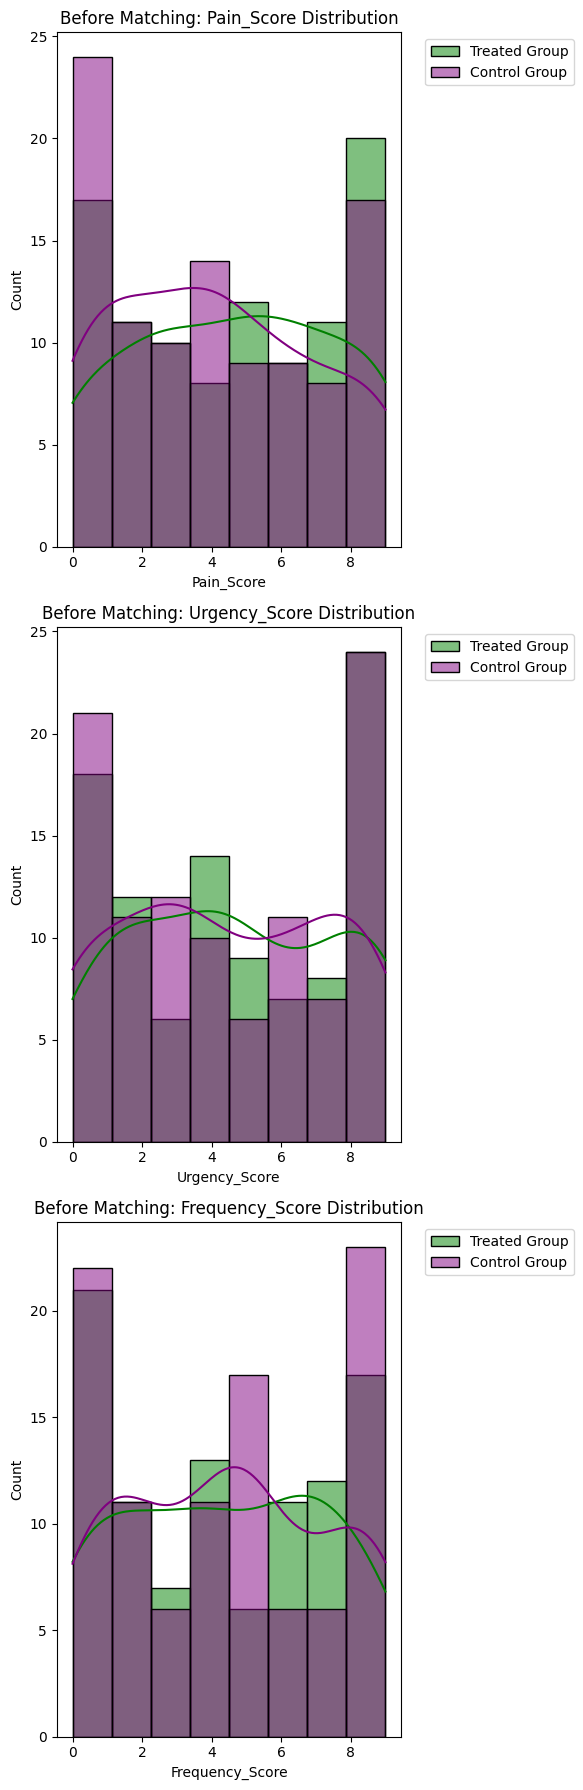

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of symptoms
symptom_list = ["Pain_Score", "Urgency_Score", "Frequency_Score"]

# Visualize distributions before matching in vertical layout
plt.figure(figsize=(6, 18))  # Adjusted size for a vertical layout
for idx, symptom in enumerate(symptom_list):
    plt.subplot(3, 1, idx + 1)  # 3 rows, 1 column
    sns.histplot(df[df["Treated"] == 1][symptom], color="green", label="Treated Group", kde=True)
    sns.histplot(df[df["Treated"] == 0][symptom], color="purple", label="Control Group", kde=True)
    plt.title(f"Before Matching: {symptom} Distribution")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend to the side

plt.tight_layout()
plt.show()

## Compute Mahalanobis Distance

In [25]:
# Function to compute Mahalanobis Distance
def compute_mahalanobis(df, treated_col, covariate_cols):
    treated = df[df[treated_col] == 1]
    control = df[df[treated_col] == 0]
    
    cov_matrix = np.cov(df[covariate_cols].T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    distances = []
    for t_idx, t_row in treated.iterrows():
        for c_idx, c_row in control.iterrows():
            diff = t_row[covariate_cols] - c_row[covariate_cols]
            distance = mahalanobis(diff, np.zeros(len(diff)), inv_cov_matrix)
            distances.append((t_idx, c_idx, distance))
    
    distance_df = pd.DataFrame(distances, columns=['Treated_ID', 'Control_ID', 'Mahalanobis_Distance'])
    return distance_df

# Compute Mahalanobis Distance
treated_col = "Treated"
covariate_cols = ["Pain_Score", "Urgency_Score", "Frequency_Score"]

distance_df = compute_mahalanobis(df, treated_col, covariate_cols)

# Display first few rows
distance_df.head()

,Treated_ID,Control_ID,Mahalanobis_Distance
0,1,0,1.670141
1,1,4,1.576782
2,1,5,1.207873
3,1,6,1.756869
4,1,10,0.747769


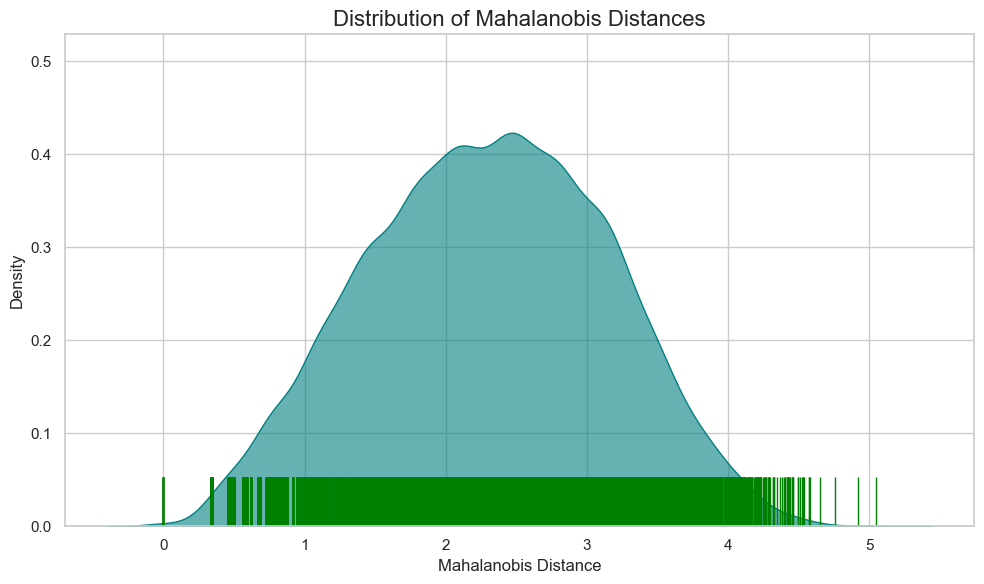

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6)) 
sns.set(style="whitegrid")  

# KDE plot with a rug plot for more details on data points
sns.kdeplot(distance_df["Mahalanobis_Distance"], color="teal", fill=True, alpha=0.6)
sns.rugplot(distance_df["Mahalanobis_Distance"], color="green", height=0.1)

# Add title and labels
plt.title("Distribution of Mahalanobis Distances", fontsize=16)
plt.xlabel("Mahalanobis Distance", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Customize the layout
plt.tight_layout()
plt.show()


## Identify Feasible Matches

In [32]:
import pandas as pd
import numpy as np

def get_feasible_pairs(df, treatment_time_col):
    treated = df[df['Treated'] == 1]
    control = df[df['Treated'] == 0]
    
    # Initialize a list to hold the feasible pairs
    feasible_pairs = []

    # Create an array of treatment times for both groups
    treated_times = treated[treatment_time_col].values
    control_times = control[treatment_time_col].values
    
    # Check feasibility: control time > treated time or control time is NaN
    for t_idx, t_row in treated.iterrows():
        feasible_controls = control[(control[treatment_time_col] > t_row[treatment_time_col]) | 
                                    control[treatment_time_col].isna()]
        
        for c_idx in feasible_controls.index:
            feasible_pairs.append((t_idx, c_idx))
    
    feasible_pairs_df = pd.DataFrame(feasible_pairs, columns=['Treated_ID', 'Control_ID'])
    return feasible_pairs_df

# Identify feasible pairs
treatment_time_col = "Treatment_Time"
feasible_pairs_df = get_feasible_pairs(df, treatment_time_col)

# Display first few rows
feasible_pairs_df.head()

,Treated_ID,Control_ID
0,1,0
1,1,4
2,1,5
3,1,6
4,1,10


## Solve Optimal Matching Using Integer Programming


In [50]:
import os
import pandas as pd
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, PULP_CBC_CMD
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'optimal_data/' directory exists before saving the output
if not os.path.exists("optimal_data"):
    os.makedirs("optimal_data")

def optimal_matching_solver(distance_df):
    """
    Solves the optimal matching problem using Integer Programming to minimize
    the total Mahalanobis distance between treated and control patients.
    """
    
    print("🔹 Initializing Integer Programming Model for Optimal Matching...")

    # Define the problem: Minimize total Mahalanobis distance
    model = LpProblem("Optimal_Matching_Problem", LpMinimize)

    # Decision Variables: 1 if matched, 0 if not
    decision_vars = {
        (row['Treated_ID'], row['Control_ID']): LpVariable(f"match_{int(row['Treated_ID'])}_{int(row['Control_ID'])}", 0, 1, cat="Binary")
        for _, row in distance_df.iterrows()
    }

    # Objective Function: Minimize total Mahalanobis distance
    print("🔹 Defining Objective: Minimize the total Mahalanobis distance...")
    model += lpSum(
        row['Mahalanobis_Distance'] * decision_vars[(row['Treated_ID'], row['Control_ID'])]
        for _, row in distance_df.iterrows()
    )

    # Constraint 1: Each treated individual must be matched to one control
    print("🔹 Adding constraints: Each treated individual must be paired exactly once...")
    for treated_id in distance_df['Treated_ID'].unique():
        model += lpSum(decision_vars[(treated_id, control_id)]
                       for control_id in distance_df[distance_df['Treated_ID'] == treated_id]['Control_ID']) == 1

    # Constraint 2: Each control individual can be matched to at most one treated individual
    print("🔹 Adding constraints: Each control individual can only be paired once...")
    for control_id in distance_df['Control_ID'].unique():
        model += lpSum(decision_vars[(treated_id, control_id)]
                       for treated_id in distance_df[distance_df['Control_ID'] == control_id]['Treated_ID']) <= 1

    # Solve the optimization model
    print("🔹 Solving the optimization problem (using CBC solver)...")
    model.solve(PULP_CBC_CMD(msg=False))

    # Extract the matched pairs where the decision variable equals 1
    matched_pairs = [(treated_id, control_id) for (treated_id, control_id), var in decision_vars.items() if var.value() == 1]

    # Convert matched pairs into a DataFrame
    matched_df = pd.DataFrame(matched_pairs, columns=['Treated_ID', 'Control_ID'])
    return matched_df

# Run the optimal matching solver on the distance data
matched_df = optimal_matching_solver(distance_df)

# Define the path to save the results
optimal_data_path = "optimal_data/optimal_matching.csv"

# Save matched pairs to a CSV file
matched_df.to_csv(optimal_data_path, index=False)

# Verify if the file was successfully saved
if os.path.exists(optimal_data_path):
    print(f"\nMatching results have been saved to: {optimal_data_path}")
else:
    print(f"\nERROR: The file 'optimal_matching.csv' could not be saved. Please check the process.")

🔹 Initializing Integer Programming Model for Optimal Matching...
🔹 Defining Objective: Minimize the total Mahalanobis distance...
🔹 Adding constraints: Each treated individual must be paired exactly once...
🔹 Adding constraints: Each control individual can only be paired once...
🔹 Solving the optimization problem (using CBC solver)...

Matching results have been saved to: optimal_data/optimal_matching.csv


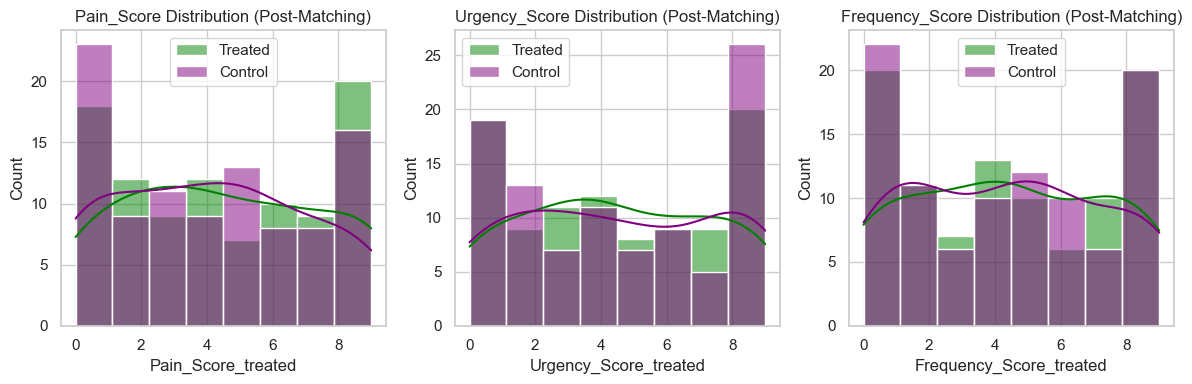

In [64]:
# Visualization of Matched Data Distributions
plt.figure(figsize=(12, 4))
for index, metric in enumerate(symptoms):
    plt.subplot(1, 3, index + 1)
    sns.histplot(matched_data[f"{metric}_treated"], color="green", label="Treated", kde=True)
    sns.histplot(matched_data[f"{metric}_control"], color="purple", label="Control", kde=True)
    plt.title(f"{metric} Distribution (Post-Matching)")
    plt.legend()

plt.tight_layout()
plt.show()

## Analyze Treatment Effects

In [55]:
# Load matched pairs from CSV
matched_df = pd.read_csv("optimal_data/optimal_matching.csv")

# Merge treated patients' symptom scores
matched_data = matched_df.merge(df, left_on='Treated_ID', right_on='ID', suffixes=('_treated', '_temp'))

# Merge control patients' symptom scores
matched_data = matched_data.merge(df, left_on='Control_ID', right_on='ID', suffixes=('_treated', '_control'))

# Debugging: Display column names
print("🔹 Available columns in merged data:", matched_data.columns.tolist())

# Calculate outcome differences
for symptom in ["Pain_Score", "Urgency_Score", "Frequency_Score"]:
    treated_col = f"{symptom}_treated"
    control_col = f"{symptom}_control"
    baseline_col = f"{symptom}_treated"  # Reference baseline from treated patient

    # Ensure required columns exist before computing differences
    if treated_col in matched_data.columns and control_col in matched_data.columns:
        matched_data[f"{symptom}_Change_Treated"] = matched_data[treated_col] - matched_data[baseline_col]
        matched_data[f"{symptom}_Change_Control"] = matched_data[control_col] - matched_data[baseline_col]
    else:
        print(f"\nERROR: Missing column {treated_col} or {control_col}")

# Display first few rows of processed data
matched_data.head()


🔹 Available columns in merged data: ['Treated_ID', 'Control_ID', 'ID_treated', 'Treated_treated', 'Pain_Score_treated', 'Urgency_Score_treated', 'Frequency_Score_treated', 'Treatment_Time_treated', 'ID_control', 'Treated_control', 'Pain_Score_control', 'Urgency_Score_control', 'Frequency_Score_control', 'Treatment_Time_control']


,Treated_ID,Control_ID,ID_treated,Treated_treated,Pain_Score_treated,Urgency_Score_treated,Frequency_Score_treated,Treatment_Time_treated,ID_control,Treated_control,Pain_Score_control,Urgency_Score_control,Frequency_Score_control,Treatment_Time_control,Pain_Score_Change_Treated,Pain_Score_Change_Control,Urgency_Score_Change_Treated,Urgency_Score_Change_Control,Frequency_Score_Change_Treated,Frequency_Score_Change_Control
0,1.0,39.0,1,0,7,0,8,NaN,39,1,7,2,1,3.0,0,0,0,2,0,-7
1,2.0,145.0,2,1,3,0,5,23.0,145,0,4,3,5,NaN,0,1,0,3,0,0
2,3.0,31.0,3,1,0,2,0,5.0,31,1,2,8,0,16.0,0,2,0,6,0,0
3,7.0,153.0,7,0,7,0,2,NaN,153,0,7,0,8,NaN,0,0,0,0,0,6
4,8.0,89.0,8,1,3,7,0,14.0,89,1,2,1,6,2.0,0,-1,0,-6,0,6


## Compute Summary Statistics

In [66]:
import scipy.stats as stats

# Function to compute treatment effect summary
def compute_treatment_effect(matched_data):
    results = {}

    for symptom in ["Pain_Score", "Urgency_Score", "Frequency_Score"]:
        treated_changes = matched_data[f"{symptom}_Change_Treated"]
        control_changes = matched_data[f"{symptom}_Change_Control"]
        
        # Compute mean change
        mean_treated = treated_changes.mean()
        mean_control = control_changes.mean()
        
        # Perform Wilcoxon Signed-Rank Test
        stat, p_value = stats.wilcoxon(treated_changes, control_changes)
        
        results[symptom] = {
            "Mean Change (Treated)": mean_treated,
            "Mean Change (Control)": mean_control,
            "Wilcoxon Test Statistic": stat,
            "p-value": p_value
        }
    
    return pd.DataFrame(results).T

# Compute treatment effect analysis
treatment_effect_df = compute_treatment_effect(matched_data)

# Display results
treatment_effect_df


,Mean Change (Treated),Mean Change (Control),Wilcoxon Test Statistic,p-value
Pain_Score,0.0,-0.381443,1616.0,0.449553
Urgency_Score,0.0,0.072165,1836.0,0.740492
Frequency_Score,0.0,-0.030928,2161.0,0.924965


In [68]:
# Save treatment effect results to CSV
treatment_effect_df.to_csv("treatment_effect_analysis.csv")

print("Treatment Effect Analysis saved successfully!")

Treatment Effect Analysis saved successfully!


## Sensitivity Analysis

In [75]:
import statsmodels.stats.descriptivestats as smd
import pandas as pd

def conduct_sensitivity_analysis(matched_data):
    """
    Conducts Rosenbaum's Sensitivity Analysis to assess the impact of unmeasured confounding 
    (represented by hidden bias, gamma) on the statistical significance of treatment effects.
    """

    print("🔹 Initiating Sensitivity Analysis...")

    # Extract treatment and control changes in symptoms
    treated_changes = matched_data["Pain_Score_Change_Treated"]
    control_changes = matched_data["Pain_Score_Change_Control"]

    # Calculate paired differences between treated and control groups
    paired_differences = treated_changes - control_changes

    # Perform the Sign Test (a non-parametric alternative to the Wilcoxon signed-rank test)
    test_stat, p_value = smd.sign_test(paired_differences, mu0=0)

    # Set different levels for gamma (sensitivity to hidden bias)
    gamma_levels = [1.0, 1.5, 2.0, 2.5, 3.0]

    # Dictionary to store sensitivity results
    sensitivity_outcomes = {}

    # Adjust p-value based on gamma levels
    for gamma in gamma_levels:
        # Approximate the adjusted p-value by multiplying with gamma
        adjusted_p_value = p_value * gamma

        # Store the adjusted p-value for each gamma level
        sensitivity_outcomes[f"Gamma={gamma}"] = adjusted_p_value

    # Convert the sensitivity analysis results to a DataFrame
    sensitivity_df = pd.DataFrame(sensitivity_outcomes, index=["Adjusted P-Value"]).T

    print("\nSensitivity Analysis Completed Successfully.")
    return sensitivity_df

# Run the sensitivity analysis
sensitivity_results_df = conduct_sensitivity_analysis(matched_data)

# Display the analysis results
sensitivity_results_df


🔹 Initiating Sensitivity Analysis...

Sensitivity Analysis Completed Successfully.


,Adjusted P-Value
Gamma=1.0,0.229864
Gamma=1.5,0.344797
Gamma=2.0,0.459729
Gamma=2.5,0.574661
Gamma=3.0,0.689593


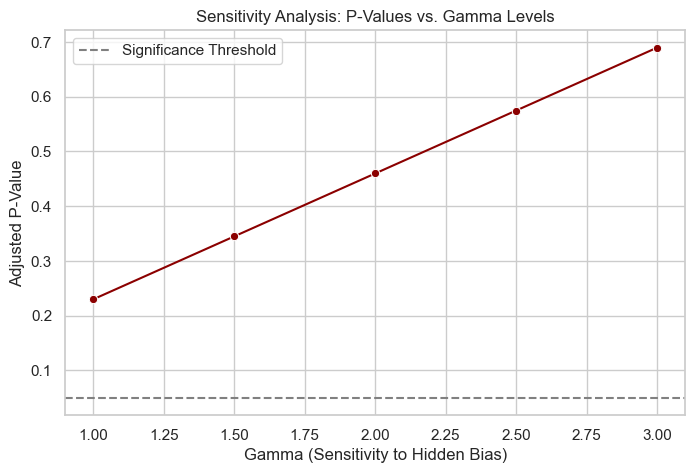

In [77]:
# Now, plot the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.lineplot(x=sensitivity_df.index.str.replace("Gamma=", "").astype(float), 
             y=sensitivity_df["Adjusted P-Value"], marker="o", color="darkred")

# Add a horizontal line at p-value = 0.05 to indicate statistical significance threshold
plt.axhline(y=0.05, color='gray', linestyle='dashed', label='Significance Threshold')

# Set plot labels and title
plt.title("Sensitivity Analysis: P-Values vs. Gamma Levels")
plt.xlabel("Gamma (Sensitivity to Hidden Bias)")
plt.ylabel("Adjusted P-Value")
plt.legend()

# Show the plot
plt.show()


In [78]:
# Save sensitivity results to CSV
sensitivity_df.to_csv("sensitivity_analysis.csv")

print("Sensitivity Analysis saved successfully!")


Sensitivity Analysis saved successfully!
